In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]=""
import utils, optimization, metrics, plot, data

# Parameters

In [3]:
ns = 64
scalings = [2, 2, 2]
nsamples = 1000
k = 10

# Data handling

Load the data

In [4]:
images, raw_images = data.load_samples(nsamples = nsamples)
images = data.make_smaller_samples(images, ns)
raw_images = data.make_smaller_samples(raw_images, ns)

Select 1000 samples out of 15000.


In [5]:
down_sampled_images = data.down_sample_images(images, scalings)

# A) Load the model

<span style="color:red">Mistakes in the following code<span style="color:blue">

In [157]:
import pickle
from model import *
from gan import *





ts = [None, None, '2018_2_2_12_49', '2018_2_2_15_41']
checkpoints = [None, None, '19800', '16000']
# checkpoints = [None, None, None, '32600']


ngan = len(scalings)+1
N = 1000
down_sampled_generated = [None]*ngan
down_sampled_generated_raw = [None]*ngan

for level in range(len(scalings),1,-1):

    try:
        del(params)
        del(obj)
    except:
        pass
    
    pathgan = '../../saved_result/LAPWGAN64_level'+str(level)+'__'+ts[level]+'checkpoints/'

    with open(pathgan+'params.pkl', 'rb') as f:
        params = pickle.load(f)
    obj = GAN(params)

    if level == len(scalings):
        gen_sample = None
#     else:
#         gen_sample = np.expand_dims(down_sampled_images[level+1][:N], axis=3)
    
    if checkpoints[level] is None:
        gen_sample, gen_sample_raw = obj.generate(N=N, y=gen_sample)
    else:
        file_name = pathgan + obj.model_name + '-' + checkpoints[level]
        print('Using checkpoint: ' +file_name)
        gen_sample, gen_sample_raw = obj.generate(N=N, y=gen_sample, file_name=file_name)
    down_sampled_generated[level] = (np.squeeze(gen_sample))
    down_sampled_generated_raw[level] = (np.squeeze(gen_sample_raw))






Generator 
------------------------------------------------------------
     The input is of size (?, 64)
     0 Full layer with 512 outputs
         Size of the variables: (?, 512)
     Reshape to (?, 2, 2, 128)
     1 Deconv layer with 128 channels
         Batch norm
         Size of the variables: (?, 4, 4, 128)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 8, 8, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 8, 8, 1)
     The output is of size (?, 8, 8, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 8, 8, 1)
     0 Conv layer with 16 channels
         Size of the variables: (?, 4, 4, 16)
     1 Conv layer with 32 channels
         Size of the variables: (?, 2, 2, 32)
     2 Conv layer with 64 channels
         Size of the variables: (?, 2, 2, 64)
     Reshape to (?, 256)
     3 Full l

Print a few samples

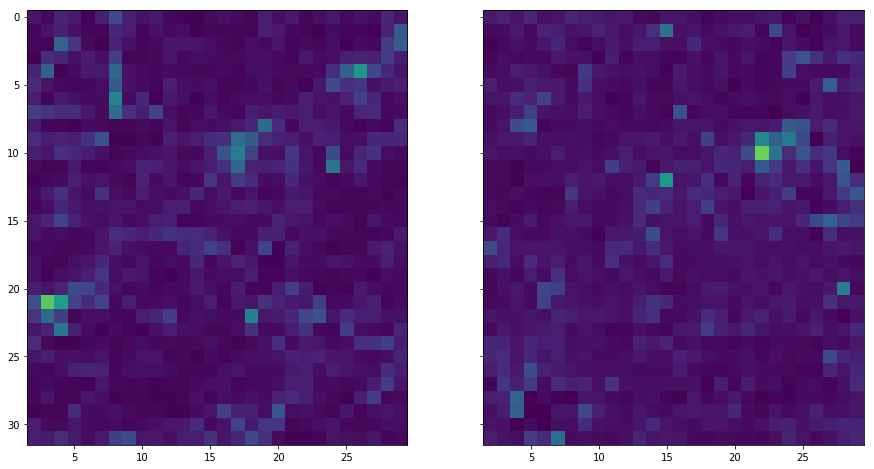

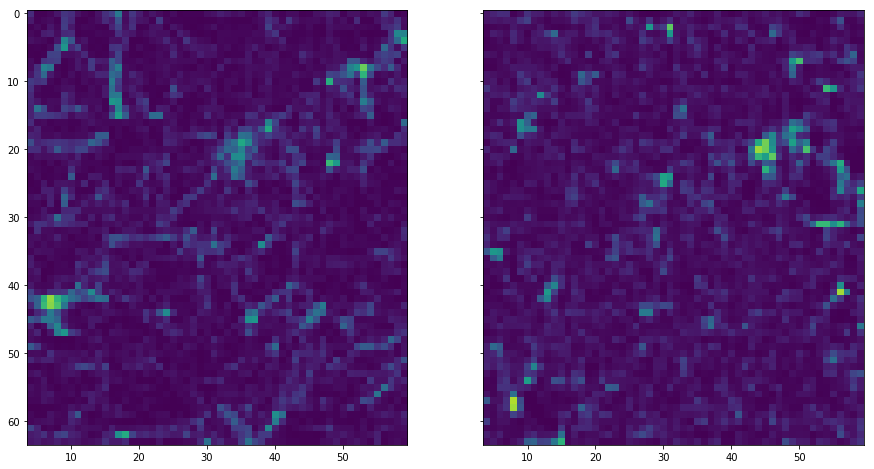

In [154]:
for level in range(len(scalings),1,-1):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8))
    utils.draw_images(np.squeeze(down_sampled_images[level]),nx=4,ny=4,axes = ax1, clim=[-1,1])
    utils.draw_images(np.squeeze(down_sampled_generated[level]),nx=4,ny=4,axes = ax2, clim=[-1,1])

# Evaluate the model

Compute the real PSD over all samples

In [115]:
psd_real_mean = [None]*ngan
psd_real = [None]*ngan
for level in range(len(scalings),1,-1):
    real_sample_raw = utils.backward_map(down_sampled_images[level],k=k)
    psd_real[level], x = metrics.power_spectrum_batch_phys(X1=real_sample_raw)
    psd_real_mean[level] = np.mean(psd_real[level], axis=0)

In [155]:
psd_gen_mean = [None]*ngan
psd_gen = [None]*ngan
x = [None]*ngan
for level in range(len(scalings),1,-1):
    psd_gen[level], x[level] = metrics.power_spectrum_batch_phys(X1=down_sampled_generated_raw[level])
    psd_gen_mean[level] = np.mean(psd_gen[level], axis=0)    
    l2, logel2, l1, logel1 = metrics.diff_psd(psd_real_mean[level], psd_gen_mean[level])
    print('Level {}\n  Log l2 PSD loss: {}\n  L2 PSD loss: {}\n  Log l1 PSD loss: {}\n  L1 PSD loss: {}\n'.format(level, logel2, l2, logel1, l1))


Level 3
  Log l2 PSD loss: 0.10163927033581818
  L2 PSD loss: 2359.737333538831
  Log l1 PSD loss: 0.25765169821571937
  L1 PSD loss: 30.62757916382626

Level 2
  Log l2 PSD loss: 0.2980038520981256
  L2 PSD loss: 2101.7144766784727
  Log l1 PSD loss: 0.38507457530446076
  L1 PSD loss: 31.974611204676048



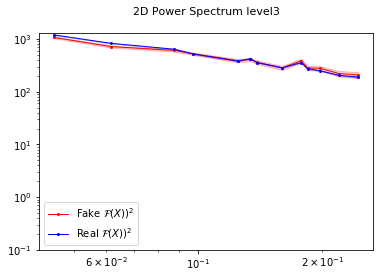

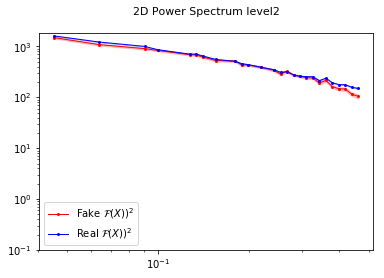

In [156]:
for level in range(len(scalings),1,-1):
    plt.figure()
    ax = plt.gca()
    ax.set_xscale("log")
    ax.set_yscale("log")
    linestyle = {"linewidth": 1, "markeredgewidth": 0, "markersize": 3, "marker": "o", "linestyle": "-"}

    plot.plot_with_shade(ax, x[level], psd_gen[level], color='r', label="Fake $\mathcal{F}(X))^2$", **linestyle)
    plot.plot_with_shade(ax, x[level], psd_real[level], color='b', label="Real $\mathcal{F}(X))^2$", **linestyle)
    ax.set_ylim(bottom=0.1)
    ax.title.set_text("2D Power Spectrum level{}\n".format(level))
    ax.title.set_fontsize(11)
    ax.tick_params(axis='both', which='major', labelsize=10)
    _ = ax.legend()


In [27]:

# sigma_smooth = [0,0.5,1]
# plot.plot_images_psd(real_sample_raw,'' , sigma_smooth = sigma_smooth)
# plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = sigma_smooth)

In [171]:
params

{'clip_max_real': False,
 'discriminator': {'batch_norm': [False, False, False, False],
  'full': [128],
  'minibatch_reg': False,
  'nfilter': [16, 128, 128, 64],
  'shape': [[5, 5], [5, 5], [3, 3], [3, 3]],
  'stride': [2, 2, 2, 1],
  'summary': True},
 'generator': {'batch_norm': [False, False, False],
  'latent_dim': 64,
  'nfilter': [64, 128, 64, 1],
  'non_lin': 'tanh',
  'shape': [[5, 5], [5, 5], [5, 5], [5, 5]],
  'stride': [1, 1, 2, 1],
  'summary': True,
  'upsampling': 2},
 'image_size': [16, 16],
 'k': 10,
 'log_clip': 0.1,
 'model': model.LapGanModel,
 'name': 'LAPWGAN64_level2_',
 'normalize': False,
 'optimization': {'batch_size': 16,
  'beta1': 0.0,
  'beta2': 0.9,
  'disc_learning_rate': 3e-05,
  'disc_optimizer': 'adam',
  'epoch': 10,
  'epsilon': 1e-08,
  'gamma_gp': 10,
  'gen_learning_rate': 3e-05,
  'gen_optimizer': 'adam',
  'optimizer': 'adam',
  'weight_l2': 0.1},
 'prior_distribution': 'gaussian',
 'save_dir': '../../saved_result/LAPWGAN64_level2__2018_2_2_12